<a href="https://colab.research.google.com/github/tselane2110/SSCLNet-Implementation/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from matplotlib import pyplot as plt
import seaborn as sns

## Import Dataset

In [2]:
import kagglehub

# Download SARTAJ Dataset
ds_4class_path = kagglehub.dataset_download("sartajbhuvaji/brain-tumor-classification-mri")

print("Path to dataset files:", ds_4class_path)

Using Colab cache for faster access to the 'brain-tumor-classification-mri' dataset.
Path to dataset files: /kaggle/input/brain-tumor-classification-mri


In [3]:
# Download latest version
ds_2class_path = kagglehub.dataset_download("navoneel/brain-mri-images-for-brain-tumor-detection")

print("Path to dataset files:", ds_2class_path)

Using Colab cache for faster access to the 'brain-mri-images-for-brain-tumor-detection' dataset.
Path to dataset files: /kaggle/input/brain-mri-images-for-brain-tumor-detection


## Exploratory Data Analysis

In [4]:

import os

os.listdir(ds_4class_path)

['Training', 'Testing']

In [5]:
def count_images(dir_path):
    count = 0
    for root, dirs , files in os.walk(dir_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                count += 1
    return count

### Brain Tumor Dataset with 2 Classes

In [6]:
import pandas as pd

yes_dir = os.path.join(ds_2class_path, 'yes')
no_dir = os.path.join(ds_2class_path, 'no')

# Create dataframe for 2-class dataset
data_2class = {'Directory': ['yes', 'no'],
               'Number of Images': [count_images(yes_dir), count_images(no_dir)]}
df_2class = pd.DataFrame(data_2class)

print("\nImage distribution in the 2-class dataset:")
display(df_2class)


Image distribution in the 2-class dataset:


,Directory,Number of Images
0,yes,155
1,no,98


### Brain Tumor Dataset with 4 Classes

In [7]:
train_dir = os.path.join(ds_4class_path, 'Training')
test_dir = os.path.join(ds_4class_path, 'Testing')

ds_4class_names = os.listdir(f'{ds_4class_path}/Training')
ds_4class_count = []

for c in ds_4class_names:
  img_count = count_images(os.path.join(train_dir, c)) + count_images(os.path.join(test_dir, c))
  ds_4class_count.append(img_count)

# Create dataframe for the 4-class dataset
data_4class = {'Class': ds_4class_names,
               'Number of Images': ds_4class_count}
df_4class = pd.DataFrame(data_4class)

# Display the dataframe for the first dataset
print("Image distribution in the 4-class dataset:")
display(df_4class)

Image distribution in the 4-class dataset:


,Class,Number of Images
0,no_tumor,500
1,pituitary_tumor,901
2,meningioma_tumor,937
3,glioma_tumor,926


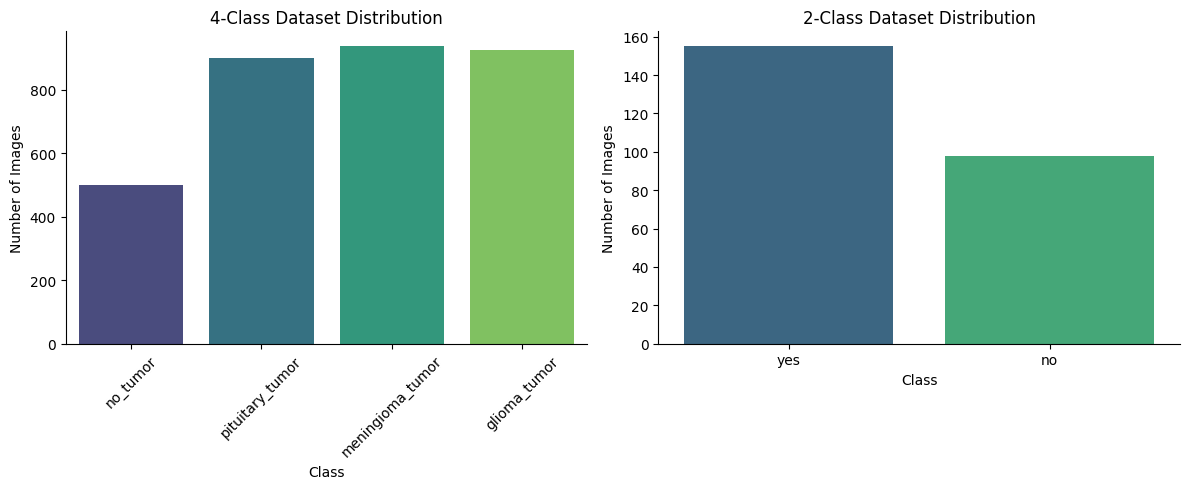

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot for 4-class dataset
sns.barplot(x='Class', y='Number of Images', data=df_4class, ax=axes[0],
            hue = 'Class', palette='viridis')
axes[0].set_title('4-Class Dataset Distribution')
axes[0].tick_params(axis='x', rotation=45)
axes[0].spines[['top', 'right',]].set_visible(False)


# Plot for 2-class dataset
sns.barplot(x='Directory', y='Number of Images', data=df_2class, ax=axes[1],
            hue = 'Directory', palette='viridis')
axes[1].set_xlabel('Class')
axes[1].set_title('2-Class Dataset Distribution')
axes[1].spines[['top', 'right',]].set_visible(False)


plt.tight_layout()
plt.show()

### Observations
* 2-Class dataset does not have 5000+ images as listed in the paper. It only has around 250 images.



## Data Preprocessing

## SSCLNET Architecture



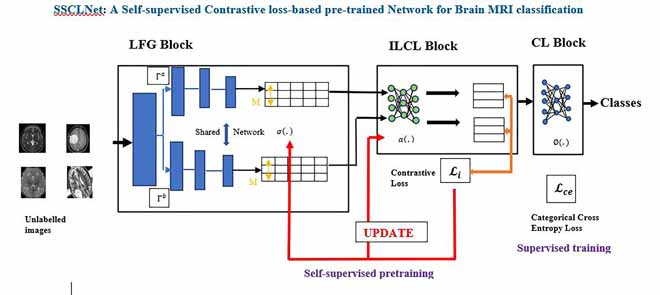

### LFG Block

### ILCL Block

### CL Block